# v0 AgriNet

The first task for the AI chain is to generate NIR images from RGB reference images to be further processed to yield NDVI and NDWI.
The model used will be the popular Pix2PixHD model from NVIDIA, which is a conditional GAN that learns a mapping from input images to output images.

In [3]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

2024-01-20 17:20:03.858313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# NIRScene0 Dataset
We need a set of pairs of RGB and NIR images to train the model. The dataset used is the [RGB-NIR Scene Data](http://ivrlwww.epfl.ch/supplementary_material/cvpr11/nirscene1.zip) from [EPFL](https://www.epfl.ch/labs/ivrl/research/downloads/rgb-nir-scene-dataset/), which contains 477 images in 9 scene categories (country, field, forest, indoor, mountain, oldbuilding, street, urban, water) at 1024x768 resolution.



In [6]:
dataset_path = pathlib.Path("/Users/adambyrne/Datasets/nirscene0/jpg1")

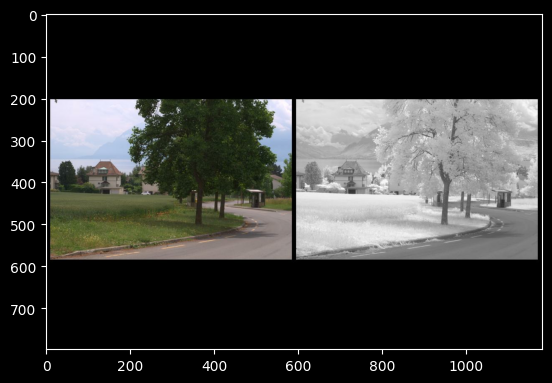

In [7]:
image_data = tf.io.read_file(str(dataset_path / "country_0000.jpg"))
image = tf.io.decode_jpeg(image_data)
plt.imshow(image.numpy())

You need to separate real building facade images from the architecture label images—all of which need to be `256 x 256` for the cGAN.

Define a function that loads image files and outputs two image tensors:

In [8]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    input_image = tf.image.resize(input_image, [256, 256])
    real_image = tf.image.resize(real_image, [256, 256])

    return real_image, input_image

Plot a sample of the input (architecture label image) and real (building facade photo) images:

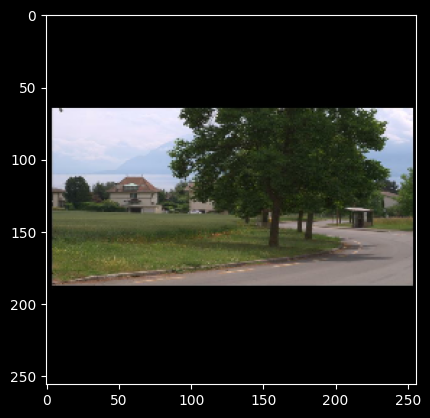

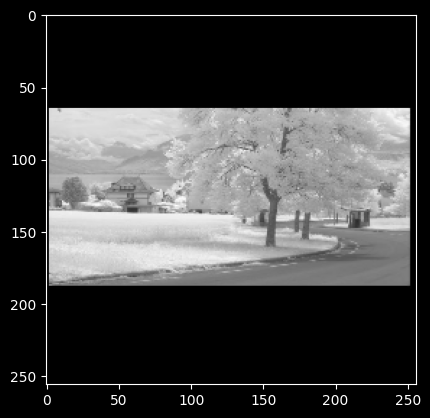

In [9]:
inp, re = load(str(dataset_path / "country_0000.jpg"))
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004){:.external}, you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e. left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [10]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [11]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(
        input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    real_image = tf.image.resize(
        real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    return input_image, real_image

In [12]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]
    )

    return cropped_image[0], cropped_image[1]

In [13]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [14]:
@tf.function()
def random_jitter(input_image, real_image):
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

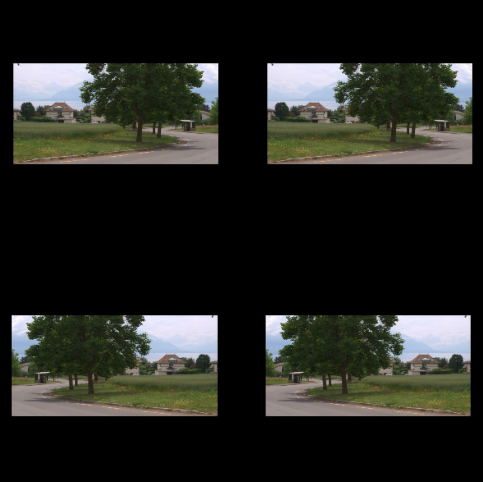

In [15]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis("off")
plt.show()

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [16]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [17]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

## Build an input pipeline with `tf.data`

In [21]:
train_dataset = tf.data.Dataset.list_files(
    "/Users/adambyrne/Datasets/nirscene0/jpg1/*.jpg"
)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [23]:
test_dataset = tf.data.Dataset.list_files(
    "/Users/adambyrne/Datasets/nirscene0/jpg2/*.jpg"
)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)